In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import os
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem import Draw

In [11]:
# Define the plotting function
def plot_model(ax, y_true, y_predicted, title):
    # Calculate RMSE and R2 coefficients
    rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
    r2 = r2_score(y_true, y_predicted)

    # Plot the data
    ax.scatter(y_true, y_predicted, label=title, color='teal', alpha=0.8)

    # Plot the diagonal line
    ax.plot([0, 100], [0, 100], color='black', linestyle='--')

    # Plot the fitting line
    fitting_line = np.polyfit(y_true, y_predicted, 1)
    ax.plot(y_true, np.polyval(fitting_line, y_true), color='r')

    # Display RMSE and R2 coefficients in the plot
    text = f'RMSE: {rmse:.2f}\nR2: {r2:.2f}'
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    ax.text(0.6, 0.1, text, transform=ax.transAxes, fontsize=12, bbox=props)



In [3]:
def molecule_fps_ecfp4(rxn):
    """
    Creates Morgan fingerprints for molecules
    """
    reactants, products = rxn.split('>>')
    
    arr_reactants = np.zeros((1,))
    fps_reactants = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(reactants), 2, 2048)
    ConvertToNumpyArray(fps_reactants, arr_reactants)

    arr_products = np.zeros((1,))
    fps_products = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(products), 2, 2048)
    ConvertToNumpyArray(fps_products, arr_products)
    
    reaction_fingerprint = np.concatenate((arr_reactants, arr_products))
    return reaction_fingerprint

def molecule_fps_ecfp4_6(rxn):
    """
    Creates Morgan fingerprints for molecules
    """
    reactants, products = rxn.split('>>')
    
    arr_reactants_2 = np.zeros((1,))
    fps_reactants_2 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(reactants), 2, 2048)
    ConvertToNumpyArray(fps_reactants_2, arr_reactants_2)
    
    arr_reactants_3 = np.zeros((1,))
    fps_reactants_3 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(reactants), 3, 2048)
    ConvertToNumpyArray(fps_reactants_3, arr_reactants_3)
    arr_reactants = np.concatenate((arr_reactants_2, arr_reactants_3))

    arr_products_2 = np.zeros((1,))
    fps_products_2 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(products), 2, 2048)
    ConvertToNumpyArray(fps_products_2, arr_products_2)
    
    arr_products_3 = np.zeros((1,))
    fps_products_3 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(products), 3, 2048)
    ConvertToNumpyArray(fps_products_3, arr_products_3)   
    arr_products = np.concatenate((arr_products_2, arr_products_3))
    
    reaction_fingerprint = np.concatenate((arr_reactants, arr_products))
    return reaction_fingerprint


In [6]:
df_hte = pd.read_csv('df_hte_cluster_drfp_14.csv')

delimiter = '.'
df_hte['rxn'] = df_hte.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
df_hte.dropna(subset = ['rxn'], inplace=True)

X3_1 = df_hte['rxn'].apply(molecule_fps_ecfp4).tolist()
X3_1_1 = df_hte['rxn'].apply(molecule_fps_ecfp4_6).tolist()

X3 = np.array([json.loads(x) for x in df_hte["RXNFP_FP"]])
X3 = X3.tolist()

X3_2 = joblib.load("df_hte_cluster_labels_drfp.pickle")
X3_2 = X3_2
y3 = df_hte.YIELD.tolist()

df = pd.DataFrame({'RXNFP': X3, 'ECFP4': X3_1, 'ECFP4_6': X3_1_1, "DRFP": X3_2, "YIELD":y3, "CLUSTER": df_hte["Cluster"]})

print("Data was loaded")

Data was loaded


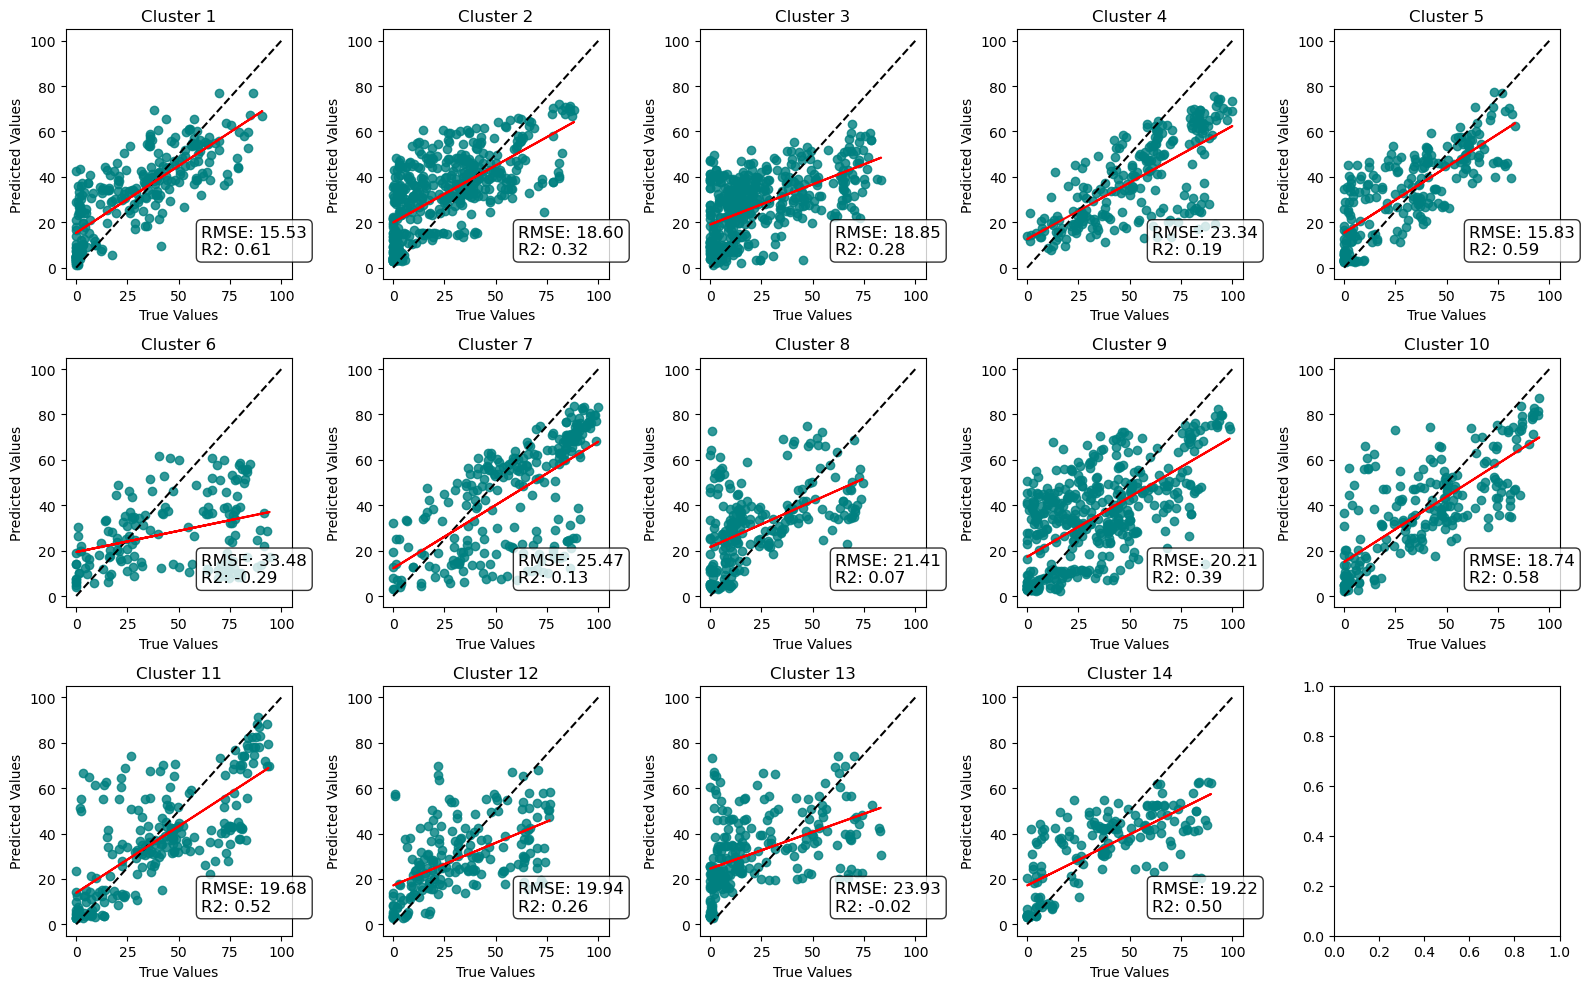

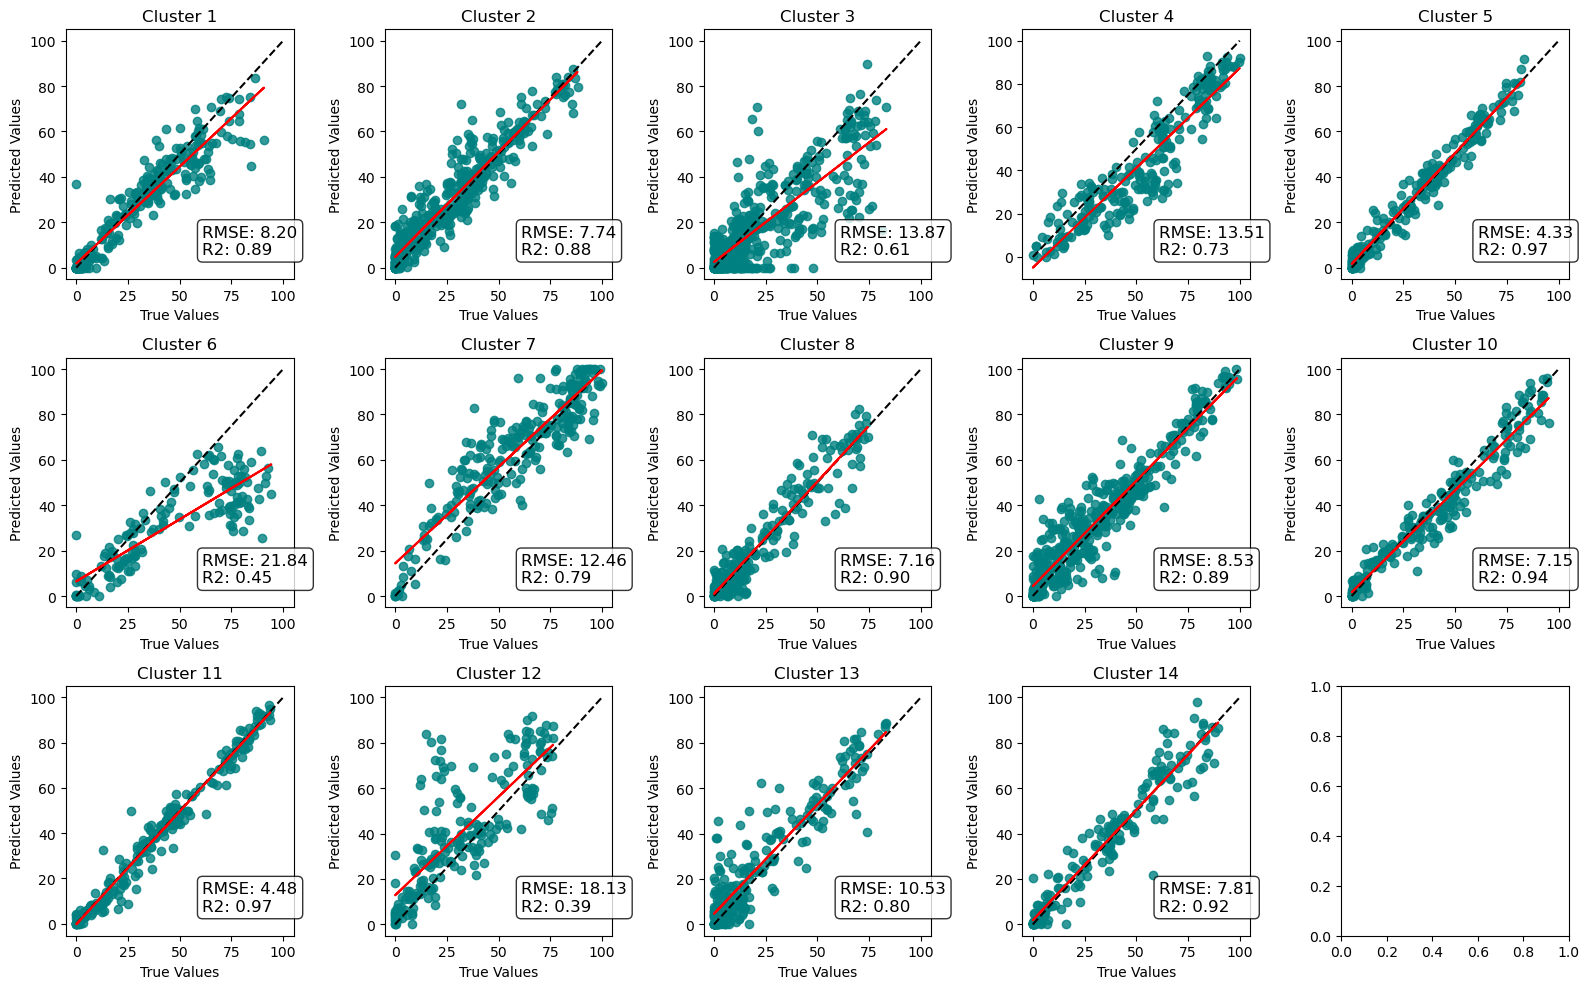

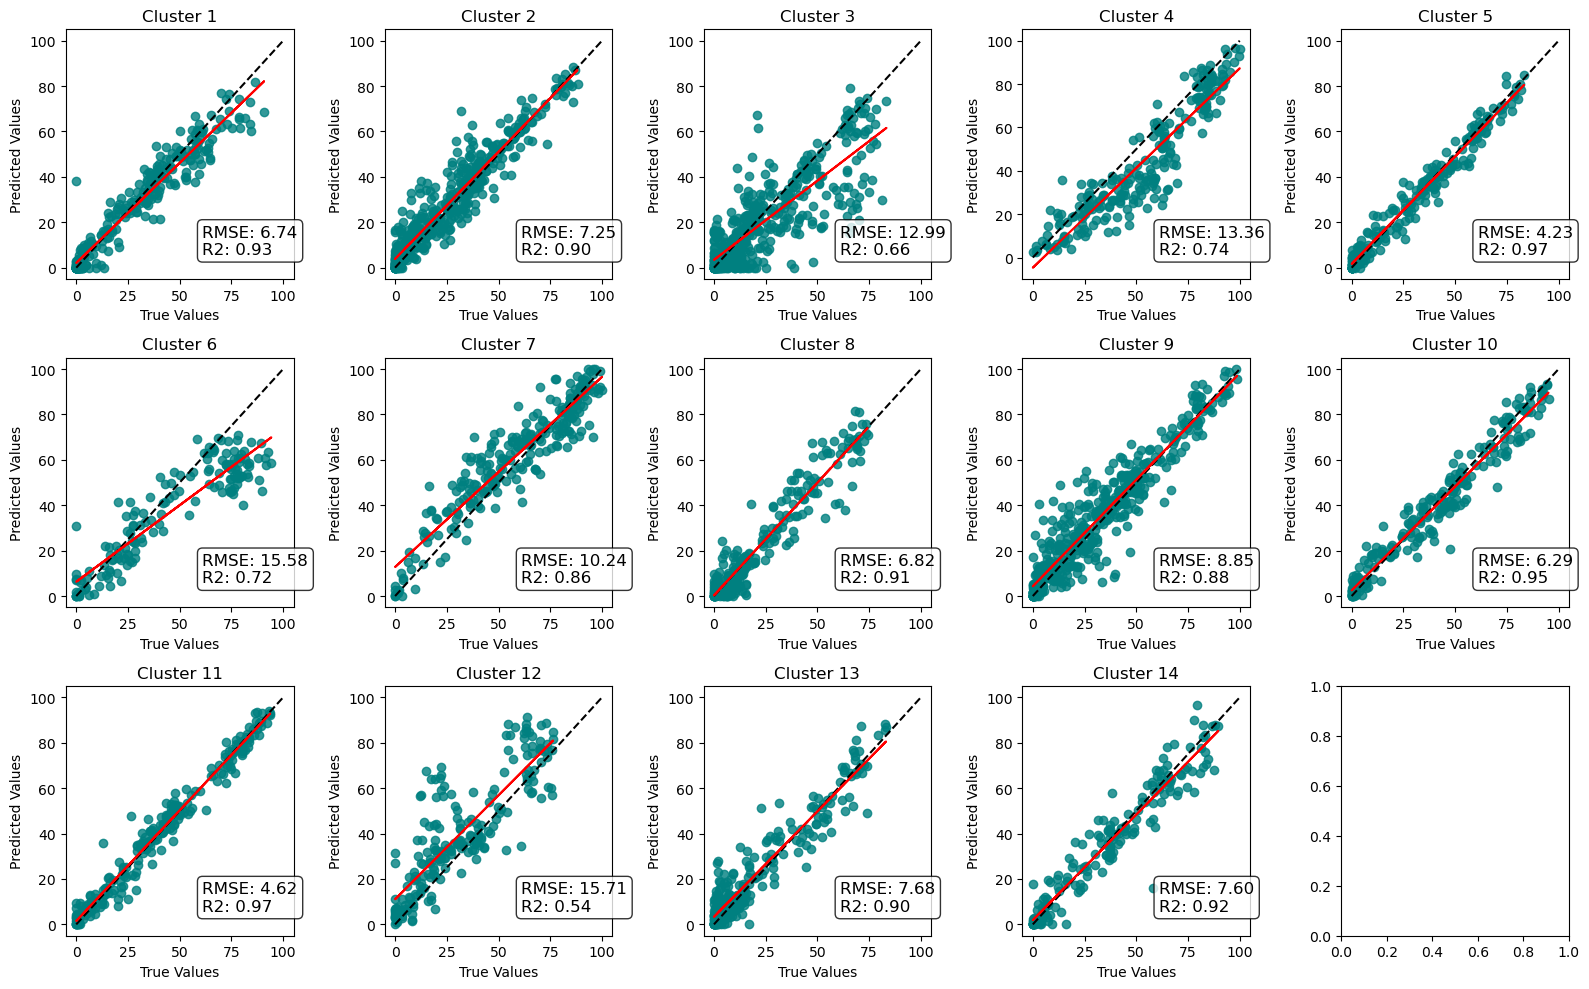

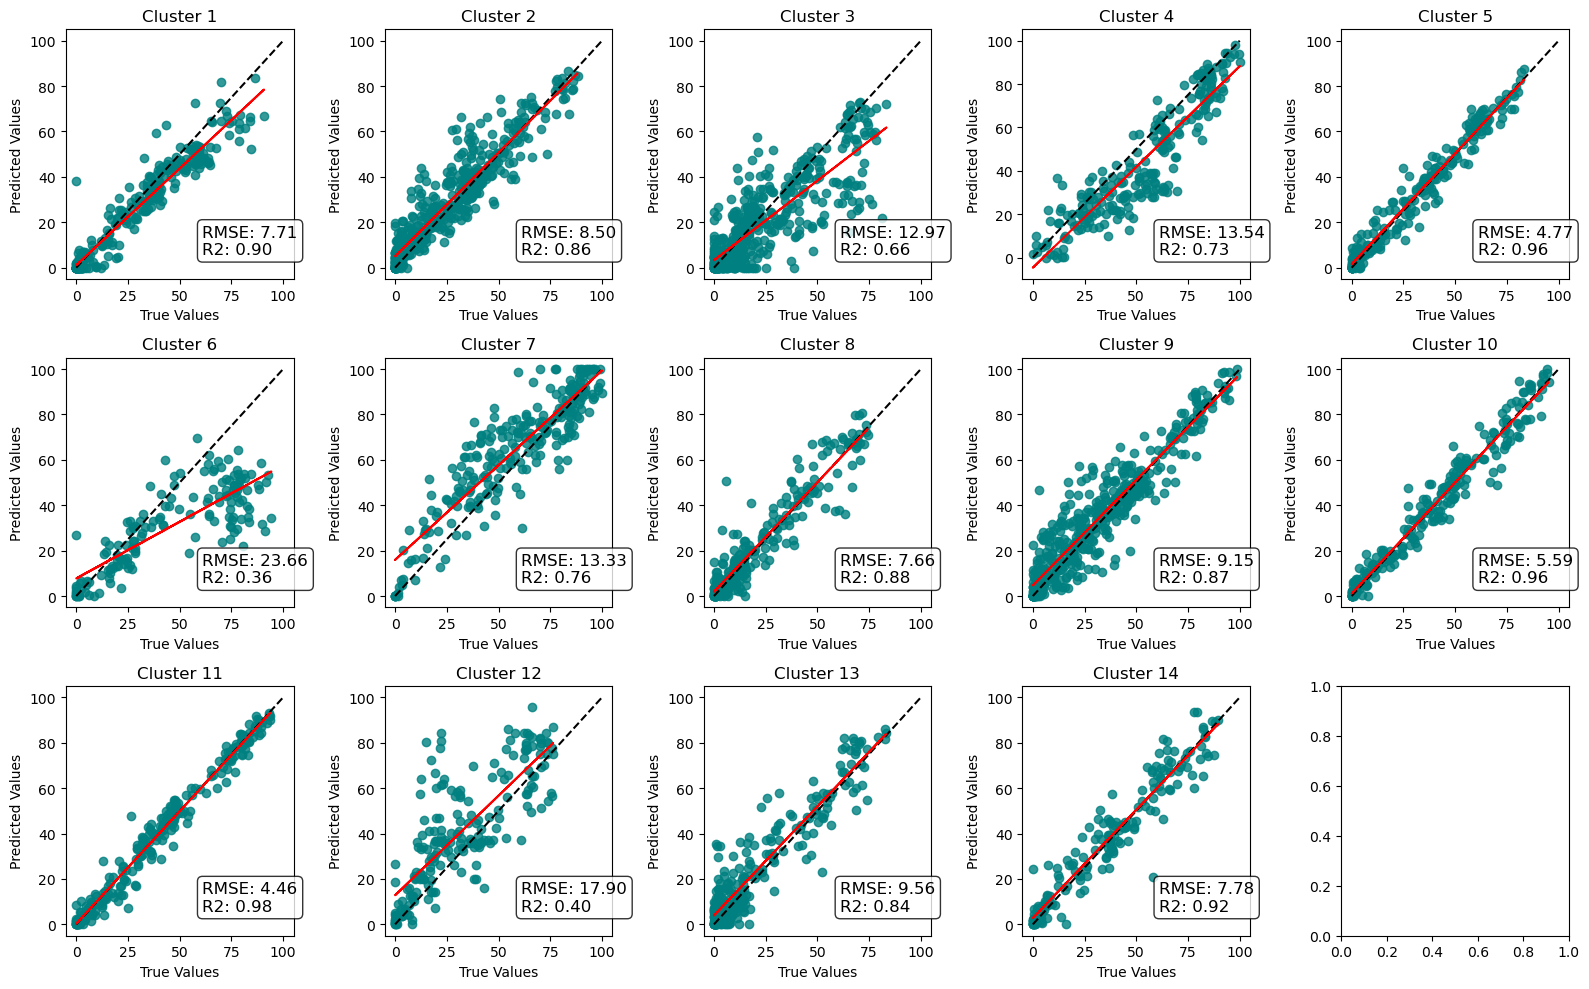

In [12]:
fp_names = ['RXNFP', 'ECFP4', 'ECFP4_6', "DRFP"]
cluster_labels = np.unique(df['CLUSTER'])

for fp_name in fp_names:
    X = df[fp_name]
    y = df['YIELD']

    # Determine the number of rows and columns for the subplots layout
    num_clusters = len(cluster_labels)
    num_rows = min(3, num_clusters)  # Maximum 3 rows
    num_cols = (num_clusters + num_rows - 1) // num_rows

    # Create the subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 10), gridspec_kw={'width_ratios': [1]*num_cols})

    # Flatten the axs array to make it easier to iterate over all subplots
    axs = axs.flatten()

    for i, cluster in enumerate(cluster_labels):
        # Get the best model for the current cluster
        best_model = joblib.load(f"./models/model_cluster_{cluster}_fingerprint_{fp_name}.joblib")

        # Get the test data for the current cluster
        test_indices = df['CLUSTER'] == cluster
        X_test, y_test = np.array(X[test_indices].tolist()), np.array(y[test_indices])

        # Make predictions using the best model for the current cluster
        y_pred = best_model.predict(X_test)
        y_pred = np.clip(y_pred, 0, 100)
        # Calculate the row and column indices for the current subplot
        row = i // num_cols
        col = i % num_cols

        # Call the plotting function for each cluster with the respective subplot
        plot_model(axs[i], y_test, y_pred, "")

        # Set labels and title for each subplot
        axs[i].set_xlabel('True Values')
        axs[i].set_ylabel('Predicted Values')
        axs[i].set_title(f'Cluster {cluster+1}')

        # Add legend to each subplot
#        axs[i].legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Save the combined plot
    plt.savefig(f"./combined_plots_{fp_name}.png", dpi=300)

    plt.show()